In [1]:
# --- IMPORTS ---
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Define a function which will evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Perform 10-fold cross-validation on the training set (using MAE and R2 metrics)
    mae_train = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    r2_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

    # Fit on full training set and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Return results
    return mae_train.mean(), r2_train.mean(), mae_test, r2_test

In [3]:
# Load data
data = pd.read_csv('steel.csv')
X = data.drop("tensile_strength", axis=1)
y = data["tensile_strength"]

# Create train/test split (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Setup 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True)

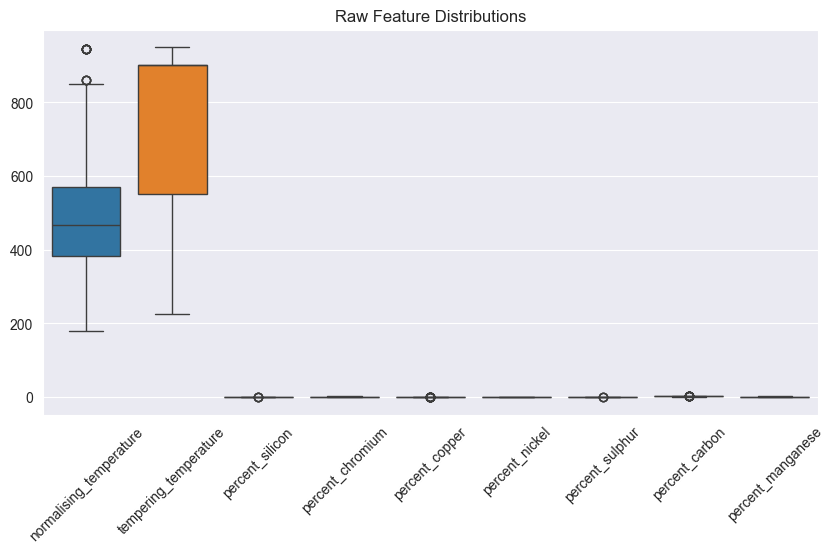

In [8]:
features = data.drop('tensile_strength', axis=1) # Drop prediction column, keep rest of features

# Create a boxplot to show raw feature distributions (no pre-processing)
plt.figure(figsize=(10,5))
sns.boxplot(data=features)
plt.title("Raw Feature Distributions")
plt.xticks(rotation=45)
plt.show()

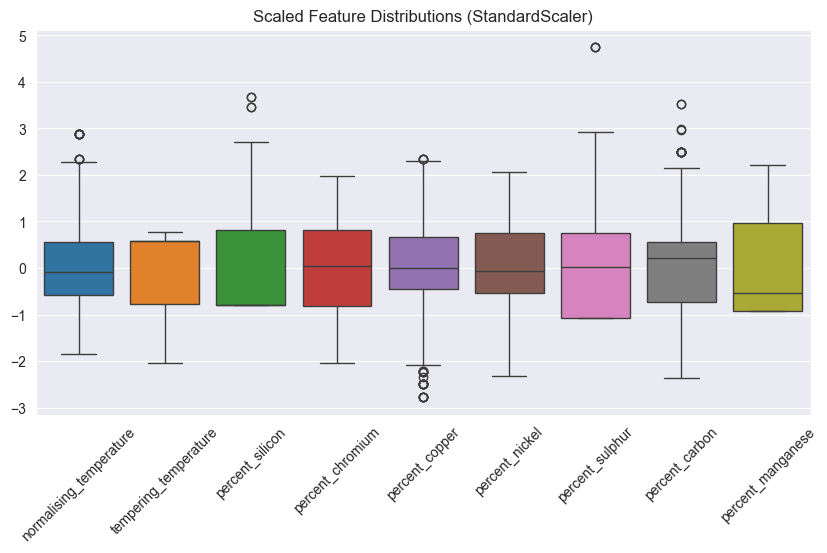

In [9]:
# Apply pre-processing (scale values of features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop('tensile_strength', axis=1))
X_scaled_df = pd.DataFrame(X_scaled, columns=data.columns[:-1])

# Create a boxplot to show feature distributions after pre-processing
plt.figure(figsize=(10,5))
sns.boxplot(data=X_scaled_df)
plt.title("Scaled Feature Distributions (StandardScaler)")
plt.xticks(rotation=45)
plt.show()

In [12]:
# Create default model (no hyperparameter tuning)
default_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', DecisionTreeRegressor())
])

# Call model evaluation function and extract results into variables
default_mae_train, default_r2_train, default_mae_test, default_r2_test = evaluate_model(
    default_model, X_train, y_train, X_test, y_test
)

# Print out results for untuned model
print("=== DEFAULT DECISION TREE MODEL RESULTS ===")
print(f"Training MAE: {default_mae_train:.3f}, Training R²: {default_r2_train:.3f}")
print(f"Test     MAE: {default_mae_test:.3f}, Test     R²: {default_r2_test:.3f}")

=== DEFAULT DECISION TREE MODEL RESULTS ===
Training MAE: 32.317, Training R²: 0.739
Test     MAE: 22.702, Test     R²: 0.833


In [13]:
# Create grid for chosen hyperparameters
param_grid = {
    'regressor__max_depth': [3, 5, 7, 9, None],
    'regressor__min_samples_split': [2, 5, 10]
}

# Create tuned model (with GridSearchCV for hyperparameter tuning)
tuned_model = GridSearchCV(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor())
    ]),
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

# Fit the GridSearchCV on the training data
tuned_model.fit(X_train, y_train)

# Extract the best performing model into variable
best_estimator = tuned_model.best_estimator_

# Call model evaluation function with best performing model and extract results into variables
tuned_mae_train, tuned_r2_train, tuned_mae_test, tuned_r2_test = evaluate_model(
    best_estimator, X_train, y_train, X_test, y_test
)

# Print out results for tuned model
print("\n=== TUNED DECISION TREE MODEL RESULTS ===")
print("Best hyperparameters:", tuned_model.best_params_)
print(f"Training MAE: {tuned_mae_train:.3f}, Training R²: {tuned_r2_train:.3f}")
print(f"Test     MAE: {tuned_mae_test:.3f}, Test     R²: {tuned_r2_test:.3f}")


=== TUNED DECISION TREE MODEL RESULTS ===
Best hyperparameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 2}
Training MAE: 29.126, Training R²: 0.770
Test     MAE: 24.051, Test     R²: 0.802


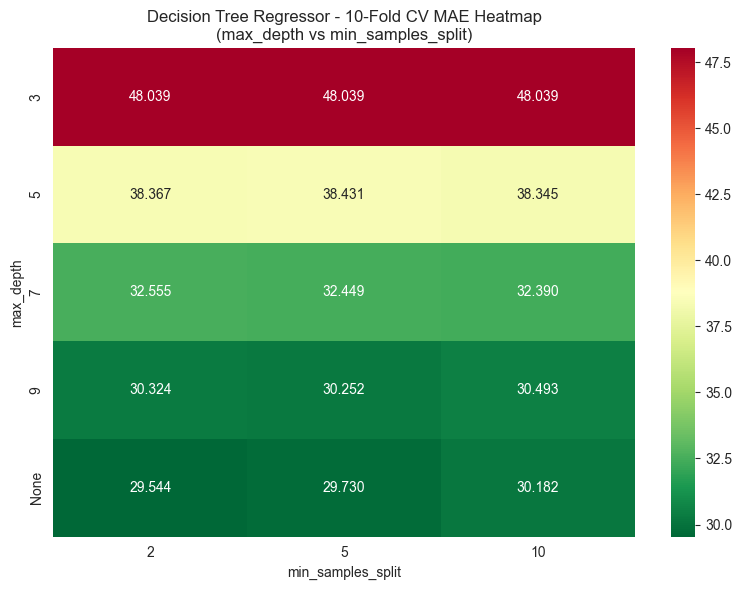

In [21]:
# Convert GridSearchCV results to a dataframe
results = pd.DataFrame(tuned_model.cv_results_)

# Extract relevant columns
results = results[[
    'param_regressor__max_depth',
    'param_regressor__min_samples_split',
    'mean_test_score'
]]

# Convert None in max_depth to String for heatmap labels
results['param_regressor__max_depth'] = results['param_regressor__max_depth'].astype(str)

# Convert negative MAE to positive
results['MAE'] = -results['mean_test_score']

# Pivot table for the heatmap
heatmap_data = results.pivot(
    index='param_regressor__max_depth',
    columns='param_regressor__min_samples_split',
    values='MAE'
)

# Create heatmap of MAE results
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='RdYlGn_r')
plt.title("Decision Tree Regressor - 10-Fold CV MAE Heatmap\n(max_depth vs min_samples_split)")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()